In [1]:
#importing necessary libraries
import pandas as pd #for data manipulation and analysis
import numpy as np #for mathematical functions
pd.set_option('display.max_columns',None)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [2]:
#reading the dataset
df = pd.read_csv(r'D:\BOOKS\UNIPI\Sem 2\Data Mining 2\Project\Anomaly Detection\imdb_1.csv')
print(df.shape) #to check the shape of the dataset

(149531, 24)


In [3]:
#df['totalNominations'] = df['totalNominations'].apply(lambda x: 1 if x >= 1 else 0)

df['ratingClass'] = pd.cut(df['averageRating'], bins=[0, 4, 7, 10], labels=['low', 'medium', 'high'], include_lowest=True)

df.drop(columns = ['titleType', 'averageRating'], axis = 1, inplace = True)
y = df['ratingClass']

In [4]:
df['ratingClass'].value_counts()/len(df)

ratingClass
high      0.500913
medium    0.464399
low       0.034688
Name: count, dtype: float64

In [5]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df.drop(columns = ['ratingClass'], axis = 1))

# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, stratify = y, test_size= 0.3, random_state = 42)

# DecisionTreeClassifier

In [6]:
# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, class_weight=None)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6316094516272849
Classification Report:
               precision    recall  f1-score   support

        high       0.67      0.67      0.67     22471
         low       0.17      0.20      0.18      1556
      medium       0.63      0.62      0.62     20833

    accuracy                           0.63     44860
   macro avg       0.49      0.50      0.49     44860
weighted avg       0.63      0.63      0.63     44860



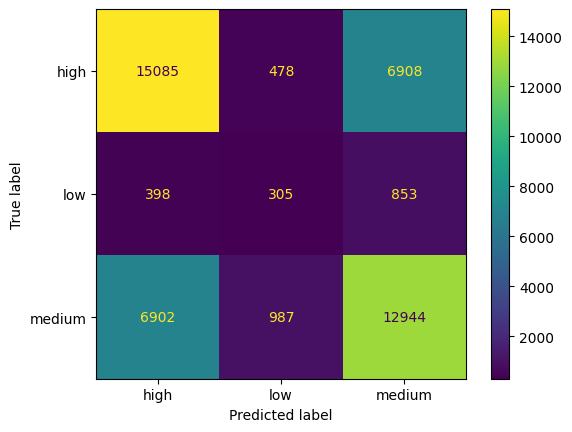

In [7]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=None,
    cmap='viridis'
)

In [8]:
#checking the feature importance
j = 0
for i in df.drop(['ratingClass'],axis = 1).columns:
    print(i, clf.feature_importances_[j])
    j+=1

startYear 0.14602823599582346
runtimeMinutes 0.17801976464178912
canHaveEpisodes 0.003185655692503885
numRegions 0.03306010200555373
ratingCount 0.12254004612100276
castNumber 0.09670839171376529
companiesNumber 0.06065861348126066
writerCredits 0.04585061652650232
directorsCredits 0.021227204946028963
totalNominations 0.014863132689952301
totalMedia 0.06341969154687381
totalReviews 0.03137129716481785
Asia 0.011571371472478744
Africa 0.0016941614740417093
Europe 0.021493121076114258
North America 0.012978094500233208
South America 0.0058295361331110445
Australia 0.0038149957479251544
Continent Unknown 0.0076091749851327165
genre1 0.052027363352953056
genre2 0.03983770457687903
genre3 0.02621172415525717


In [9]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

print(class_weight_dict)

{'high': 0.6654517458367822, 'low': 9.609343872501768, 'medium': 0.7177740656471108}


In [10]:
# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6252117699509585
Classification Report:
               precision    recall  f1-score   support

        high       0.67      0.66      0.66     22471
         low       0.18      0.19      0.19      1556
      medium       0.62      0.62      0.62     20833

    accuracy                           0.63     44860
   macro avg       0.49      0.49      0.49     44860
weighted avg       0.63      0.63      0.63     44860



In [11]:
# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, class_weight={'high': 0.2, 'low': 99, 'medium': 0.2}) # change the weights here
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6271065537226929
Classification Report:
               precision    recall  f1-score   support

        high       0.66      0.67      0.66     22471
         low       0.19      0.17      0.18      1556
      medium       0.62      0.62      0.62     20833

    accuracy                           0.63     44860
   macro avg       0.49      0.48      0.49     44860
weighted avg       0.63      0.63      0.63     44860



In [17]:
from sklearn.preprocessing import LabelEncoder

# Create encoder
le = LabelEncoder()

# Fit on training labels and transform both train & test
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, class_weight=None)
clf.fit(X_train, y_train_enc)

# Get predicted probabilities
y_pred_proba = clf.predict_proba(X_test)

# Example thresholds for each class
thresholds = [0.1, 0.6, 0.3]  # [low, medium, high]

# Custom logic for per-class thresholding
y_pred_adjusted = []

for probs in y_pred_proba:
    selected_class = None
    for i, prob in enumerate(probs):
        if prob >= thresholds[i]:
            selected_class = i
            break
    if selected_class is None:
        selected_class = np.argmax(probs)  # fallback
    y_pred_adjusted.append(selected_class)

y_pred_adjusted = np.array(y_pred_adjusted)


# Evaluate the model
accuracy = accuracy_score(y_test_enc, y_pred_adjusted)
report = classification_report(y_test_enc, y_pred_adjusted, target_names=le.classes_)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6317654926437807
Classification Report:
               precision    recall  f1-score   support

        high       0.67      0.67      0.67     22471
         low       0.17      0.20      0.18      1556
      medium       0.63      0.62      0.62     20833

    accuracy                           0.63     44860
   macro avg       0.49      0.50      0.49     44860
weighted avg       0.63      0.63      0.63     44860



In [18]:
#Decision Trees are non-probabilistic models.
#Each leaf of a decision tree is "pure" (all samples are from one class), so it outputs 0% or 100% probability.
#Thus, adjusting the threshold on 0/1 won't help — because there’s no real uncertainty inside the tree.

for i in range(100):
    print(y_pred_proba[i])

[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]

# KNN
KNN itself does not use class weights inside because it's instance-based,
so you leave the training as normal:

In [86]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.885711101203745
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     39315
           1       0.56      0.36      0.43      5545

    accuracy                           0.89     44860
   macro avg       0.74      0.66      0.69     44860
weighted avg       0.87      0.89      0.87     44860



In [98]:
# Get the predicted probabilities
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Adjust threshold manually
threshold = 0.7  # you can tune this
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_adjusted)
report = classification_report(y_test, y_pred_adjusted)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.8898796255015604
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     39315
           1       0.70      0.19      0.30      5545

    accuracy                           0.89     44860
   macro avg       0.80      0.59      0.62     44860
weighted avg       0.87      0.89      0.86     44860



In [88]:
y_pred_proba

array([0. , 0. , 0.8, ..., 0.6, 0.4, 0.2])

# XGBOOST

In [8]:
# Train XGBoost with class weight adjustment
model = xgb.XGBClassifier(
    scale_pos_weight=None,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

#Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9045920641997325
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     39315
           1       0.68      0.44      0.53      5545

    accuracy                           0.90     44860
   macro avg       0.80      0.70      0.74     44860
weighted avg       0.89      0.90      0.90     44860



In [9]:
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos

print(f"Scale pos weight: {scale_pos_weight}")

# Train XGBoost with class weight adjustment
model = xgb.XGBClassifier(
    scale_pos_weight=2, # change the weights here
    eval_metric='logloss'
)

model.fit(X_train, y_train)

#Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Scale pos weight: 7.090199412583089
Accuracy: 0.8957423094070441
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     39315
           1       0.58      0.59      0.58      5545

    accuracy                           0.90     44860
   macro avg       0.76      0.76      0.76     44860
weighted avg       0.90      0.90      0.90     44860



In [12]:
# Train XGBoost with class weight adjustment
model = xgb.XGBClassifier(
    scale_pos_weight=None, # change the weights here
    eval_metric='logloss'
)
model.fit(X_train, y_train)
# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold manually
threshold = 0.7  # threshold to detect more positives
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_adjusted)
report = classification_report(y_test, y_pred_adjusted)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.90100312082033
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     39315
           1       0.80      0.27      0.40      5545

    accuracy                           0.90     44860
   macro avg       0.85      0.63      0.67     44860
weighted avg       0.89      0.90      0.88     44860



In [13]:
y_pred_proba

array([0.01083739, 0.00278726, 0.76741534, ..., 0.12696758, 0.07125672,
       0.02828387], dtype=float32)

# LogisticRegression

In [17]:
lr = LogisticRegression(class_weight=None)
lr.fit(X_train, y_train)

# Get predicted probabilities
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8859786000891663
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     39315
           1       0.63      0.19      0.29      5545

    accuracy                           0.89     44860
   macro avg       0.76      0.59      0.61     44860
weighted avg       0.86      0.89      0.86     44860



In [19]:
lr = LogisticRegression(class_weight={0:0.1, 1:0.9}) #change the weights here
lr.fit(X_train, y_train)

# Get predicted probabilities
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7090726705305395
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.70      0.81     39315
           1       0.26      0.76      0.39      5545

    accuracy                           0.71     44860
   macro avg       0.61      0.73      0.60     44860
weighted avg       0.87      0.71      0.76     44860



In [20]:

# Train your model normally
model = LogisticRegression(class_weight=None) # change the weights here
model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold manually
threshold = 0.3  # for example, lower threshold to detect more positives
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_adjusted)
report = classification_report(y_test, y_pred_adjusted)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8769505127061971
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     39315
           1       0.50      0.32      0.39      5545

    accuracy                           0.88     44860
   macro avg       0.71      0.64      0.66     44860
weighted avg       0.86      0.88      0.86     44860

